<a href="https://colab.research.google.com/github/SongHM-cloud/project/blob/main/job_scheduling_genetic_algorithm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Generation 0: Best Makespan 3205, Average Makespan 3426.48
Generation 1: Best Makespan 3057, Average Makespan 3368.0333333333333
Generation 2: Best Makespan 3057, Average Makespan 3302.653333333333
Generation 3: Best Makespan 3054, Average Makespan 3267.633333333333
Generation 4: Best Makespan 2870, Average Makespan 3227.06
Generation 5: Best Makespan 2870, Average Makespan 3199.4266666666667
Generation 6: Best Makespan 2870, Average Makespan 3145.0933333333332
Generation 7: Best Makespan 2850, Average Makespan 3118.3866666666668
Generation 8: Best Makespan 2850, Average Makespan 3094.733333333333
Generation 9: Best Makespan 2850, Average Makespan 3067.4266666666667
Generation 10: Best Makespan 2850, Average Makespan 3047.5333333333333
Generation 11: Best Makespan 2850, Average Makespan 3016.68
Generation 12: Best Makespan 2833, Average Makespan 3024.2066666666665
Generation 13: Best Makespan 2758, Average Makespan 3021.64
Generation 14: Best Makespan 2758, Average Makespan 3001.373333

<ipython-input-4-8ad2e1d8d460>:103: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('nipy_spectral', len(jobs))


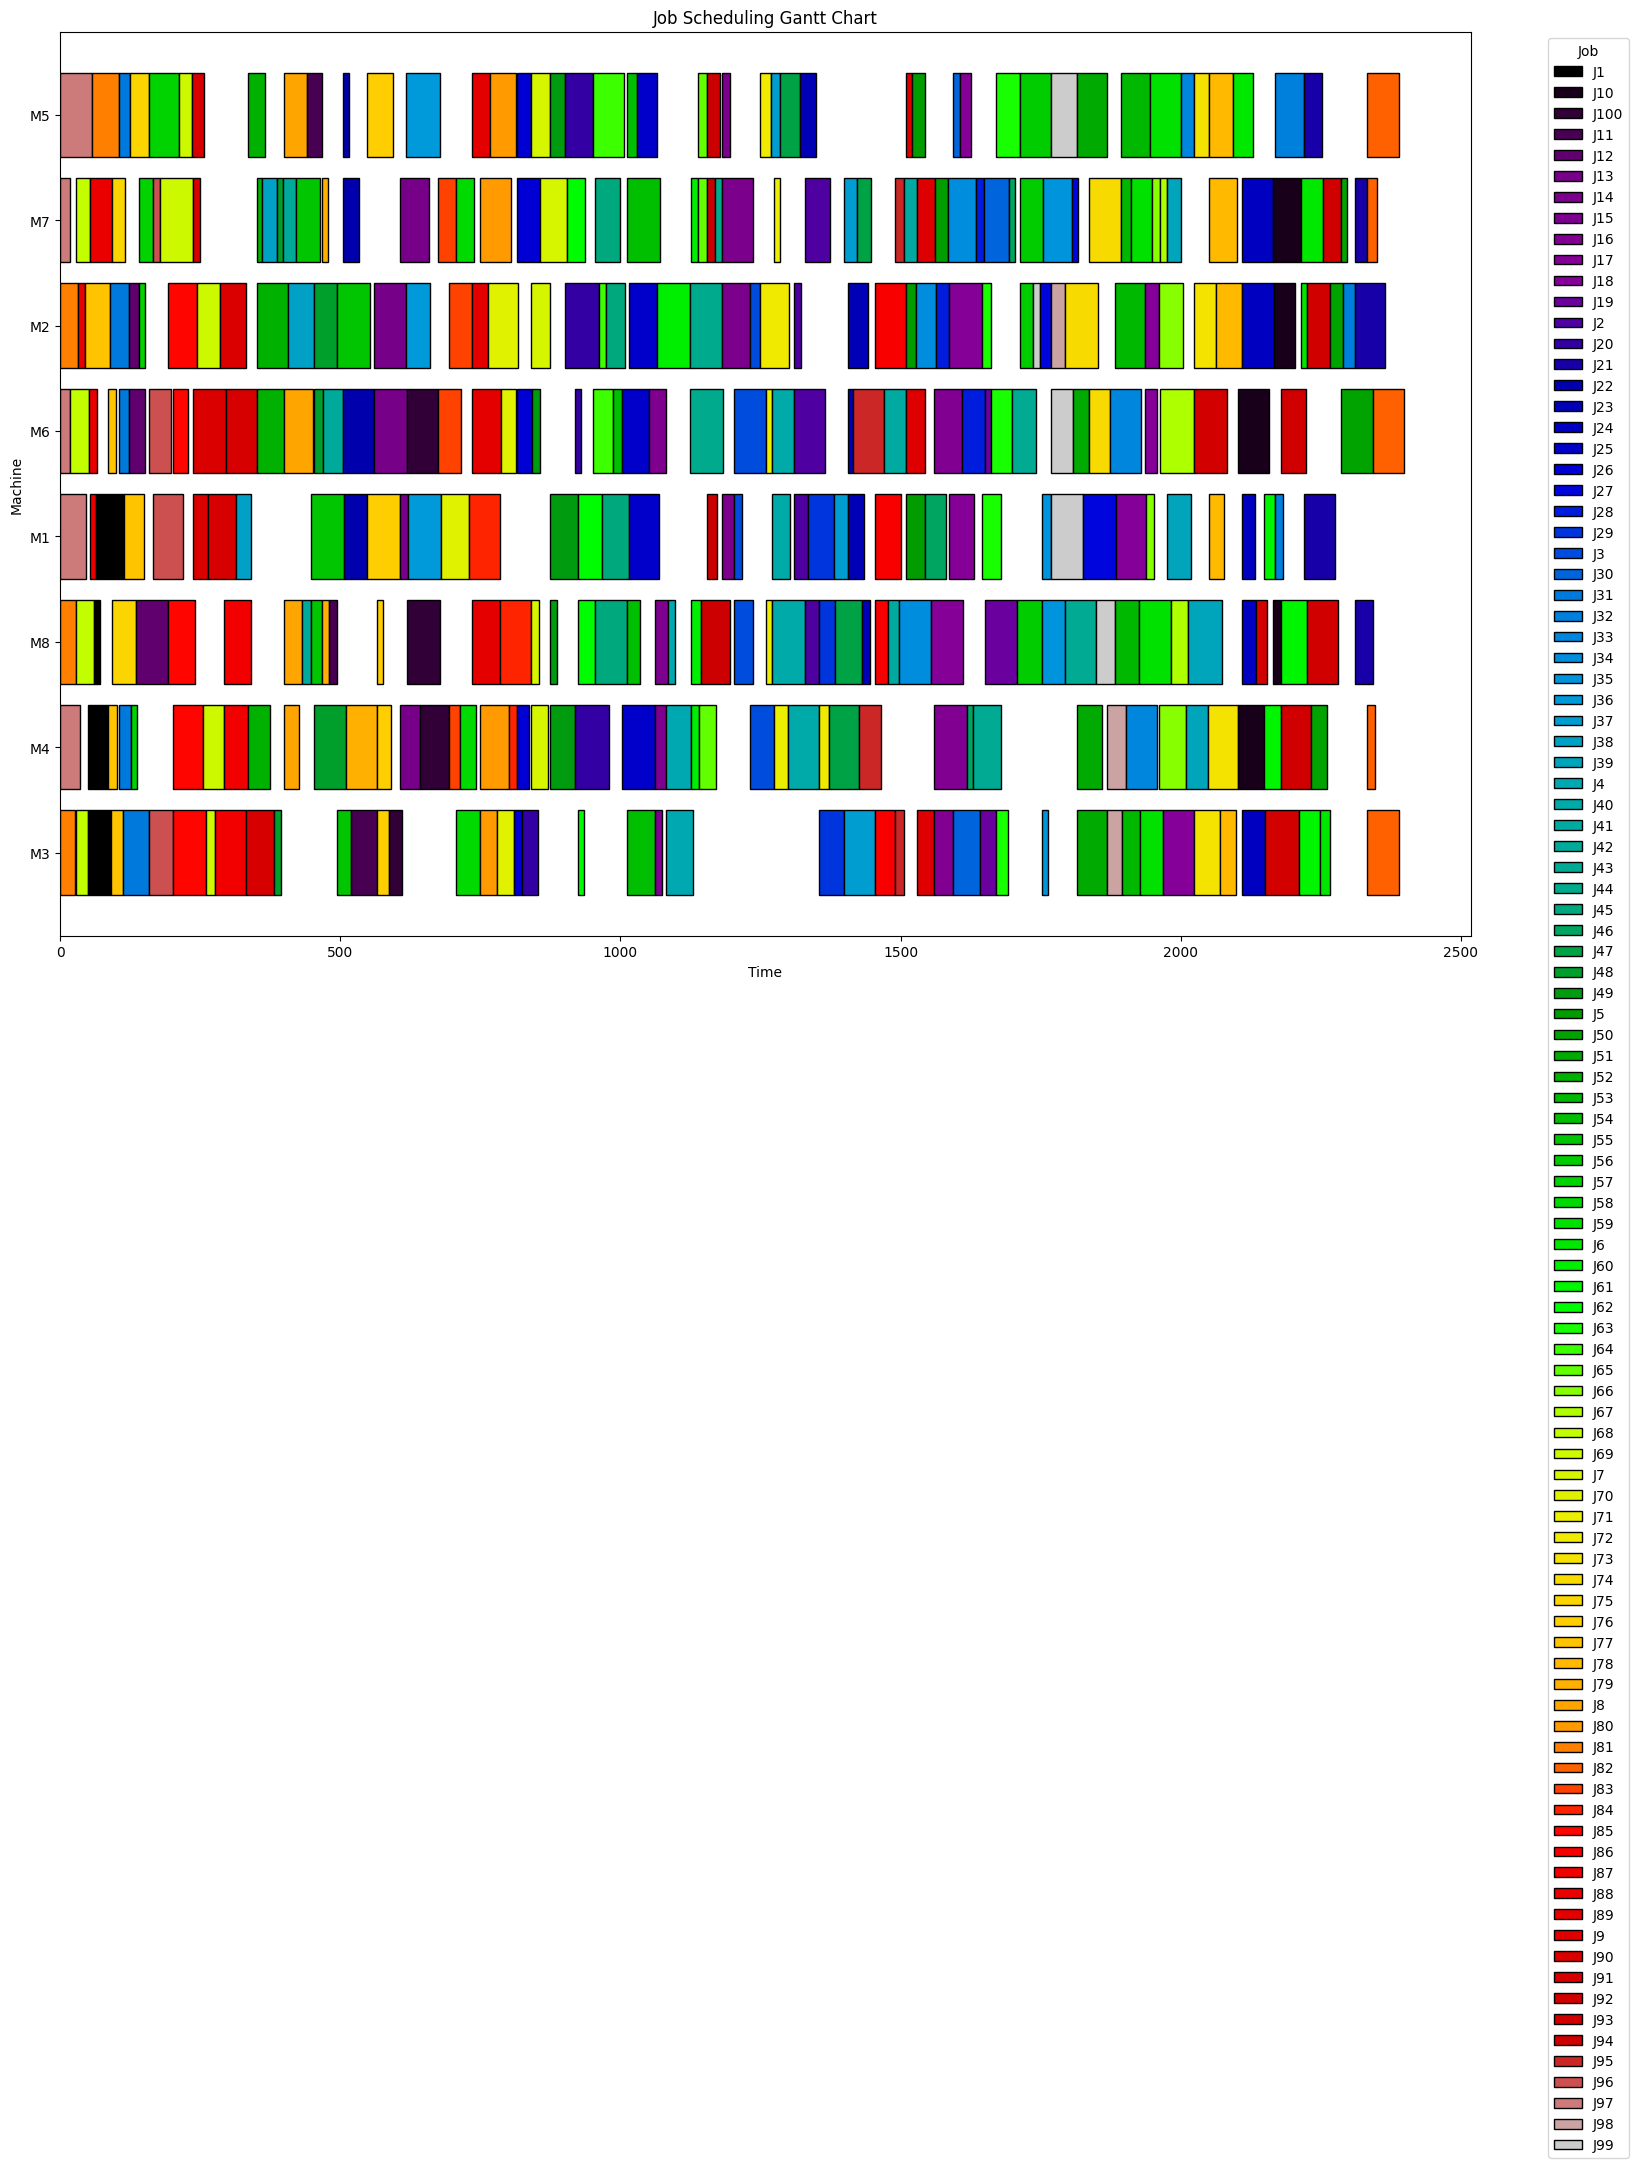

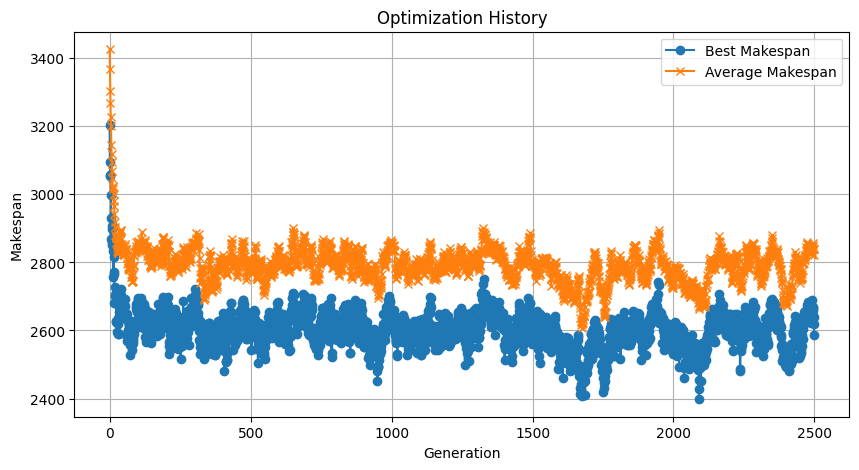

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import ast

# 파일에서 데이터를 불러오는 함수
def load_data(file_path):
    input_data = {}
    with open(file_path, 'r') as file:
        for line in file:
            if line.strip():  # 빈 줄은 무시
                job, tasks = line.split(':', 1)
                job = job.strip().strip("'")  # 작업 이름에서 따옴표와 공백 제거
                tasks = eval(tasks.strip())  # 각 작업의 머신과 시간을 리스트로 변환
                if isinstance(tasks, tuple):  # 튜플로 감싸진 경우 리스트로 변환
                    tasks = tasks[0]
                input_data[job] = tasks
    return input_data

# 유전 알고리즘을 위한 클래스
class JobShopGA:
    def __init__(self, inputData, population_size=150, generations=2500, mutation_rate=0.2):
        self.inputData = inputData
        self.population_size = population_size
        self.generations = generations
        self.mutation_rate = mutation_rate
        self.jobs = list(inputData.keys())
        self.population = [np.random.permutation(self.jobs) for _ in range(population_size)]

    def calculate_makespan(self, chromosome):
        machine_times = {machine: 0 for job in self.inputData for machine, _ in self.inputData[job]}
        job_times = {job: 0 for job in self.inputData}
        machine_job_schedule = {machine: [] for job in self.inputData for machine, _ in self.inputData[job]}

        for job in chromosome:
            start_time = job_times[job]
            for machine, duration in self.inputData[job]:
                start_time = max(start_time, machine_times[machine])
                end_time = start_time + duration
                machine_times[machine] = end_time
                job_times[job] = end_time
                machine_job_schedule[machine].append((job, start_time, end_time))

        return max(machine_times.values()), machine_job_schedule

    def selection(self):
        new_population = []
        tournament_size = 5
        for _ in range(self.population_size):
            tournament = [self.population[np.random.randint(len(self.population))] for _ in range(tournament_size)]
            tournament_fitness = [self.calculate_makespan(chromosome)[0] for chromosome in tournament]
            new_population.append(tournament[np.argmin(tournament_fitness)])
        return new_population

    def crossover(self, parent1, parent2):
        size = len(parent1)
        cxpoint = np.random.randint(size)
        child1 = np.hstack((parent1[:cxpoint], [x for x in parent2 if x not in parent1[:cxpoint]]))
        child2 = np.hstack((parent2[:cxpoint], [x for x in parent1 if x not in parent2[:cxpoint]]))
        return child1, child2

    def mutate(self, chromosome):
        idx1, idx2 = np.random.randint(len(chromosome), size=2)
        chromosome[idx1], chromosome[idx2] = chromosome[idx2], chromosome[idx1]
        return chromosome

    def run(self):
        best_solution = None
        best_makespan = float('inf')
        best_schedule = None
        history = []
        average_history = []

        for generation in range(self.generations):
            new_population = self.selection()
            children = []
            makespans = []
            for i in range(0, self.population_size, 2):
                if i+1 < self.population_size:
                    c1, c2 = self.crossover(new_population[i], new_population[i+1])
                    c1 = self.mutate(c1)
                    c2 = self.mutate(c2)
                    children.extend([c1, c2])
                    makespans.extend([self.calculate_makespan(c1)[0], self.calculate_makespan(c2)[0]])
            self.population = children
            current_best = min(makespans)
            current_average = np.mean(makespans)
            history.append(current_best)
            average_history.append(current_average)
            if current_best < best_makespan:
                best_makespan = current_best
                best_solution = self.population[np.argmin(makespans)]
                _, best_schedule = self.calculate_makespan(best_solution)

            print(f"Generation {generation}: Best Makespan {best_makespan}, Average Makespan {current_average}")

        return best_solution, best_makespan, history, average_history, best_schedule

def plot_gantt(schedule):
    fig, ax = plt.subplots(figsize=(15, 10))
    machines = list(schedule.keys())
    jobs = sorted(set(j for ms in schedule.values() for j, _, _ in ms))
    colors = plt.cm.get_cmap('nipy_spectral', len(jobs))

    job_rects = {}  # 작업별로 사각형을 저장하여 범례 생성에 사용

    for machine in machines:
        for job, start, end in schedule[machine]:
            rect = ax.barh(machine, end - start, left=start, color=colors(jobs.index(job)), edgecolor='black', label=job if job not in job_rects else "")
            job_rects[job] = rect[0]  # 각 작업에 대한 사각형 참조 저장

    ax.set_xlabel('Time')
    ax.set_ylabel('Machine')
    ax.set_title('Job Scheduling Gantt Chart')
    plt.tight_layout()

    # 범례 추가
    ax.legend(handles=[job_rects[job] for job in sorted(job_rects)],
              labels=[job for job in sorted(job_rects)],
              bbox_to_anchor=(1.05, 1), loc='upper left', title='Job')

    plt.show()

# 파일 경로 설정
file_path = '/content/InputData.txt'

# 데이터 불러오기
inputData = load_data(file_path)

# 유전 알고리즘 실행
ga = JobShopGA(inputData)
best_sequence, best_makespan, history, average_history, best_schedule = ga.run()

# 결과 출력
print("Best Solution: ", ', '.join(best_sequence))
print("Best Fitness (Makespan): ", best_makespan)

# Gantt 차트 그리기
plot_gantt(best_schedule)

# 최적화 과정 시각화
plt.figure(figsize=(10, 5))
plt.plot(history, 'o-', label='Best Makespan')
plt.plot(average_history, 'x-', label='Average Makespan')
plt.title('Optimization History')
plt.xlabel('Generation')
plt.ylabel('Makespan')
plt.legend()
plt.grid(True)
plt.show()
